# Introduction to Deep Learning for Image Classification

This notebook introduces the fundamentals of deep learning applied to image classification. We will explore:

1. **Multi-Layer Perceptron (MLP)** - A simple fully connected neural network
2. **Convolutional Neural Networks (CNN)** - Networks designed specifically for image data

We'll work with two classic datasets:
- **MNIST** - Handwritten digits (28×28 grayscale images)
- **CIFAR-10** - Color images of 10 object categories (32×32 RGB images)

---

## Setup and Imports

First, we import the necessary libraries:
- **PyTorch** (`torch`, `torch.nn`) - Deep learning framework
- **torchvision** - Computer vision utilities and datasets
- **tqdm** - Progress bars for training loops
- **matplotlib** - Visualization

In [ ]:
%pip install torch torchvision numpy tqdm matplotlib

### Device Selection

PyTorch can run on different hardware:
- **CUDA** - NVIDIA GPUs (fastest for deep learning)
- **MPS** - Apple Silicon GPUs (Metal Performance Shaders)
- **CPU** - Fallback option (slower but always available)

The code below automatically selects the best available device.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == "cpu":
    device = torch.device('mps') if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device
print(f'Using device: {device}')

Using device: cuda


# Part 1: Classification on MNIST

The **MNIST** dataset is the "Hello World" of deep learning. It contains 70,000 grayscale images of handwritten digits (0-9):
- **Training set**: 60,000 images
- **Test set**: 10,000 images
- **Image size**: 28×28 pixels

## Data Loading and Preprocessing

We use `torchvision.transforms.v2` to define preprocessing:
- `ToImage()` - Converts PIL images to tensors
- `ToDtype(torch.float32)` - Ensures float32 data type for neural network compatibility

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32),
])


mnist_train_ds = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_val_ds = MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]


### Data Visualization

Always visualize your data before training! This helps you understand what you're working with and catch potential issues early.

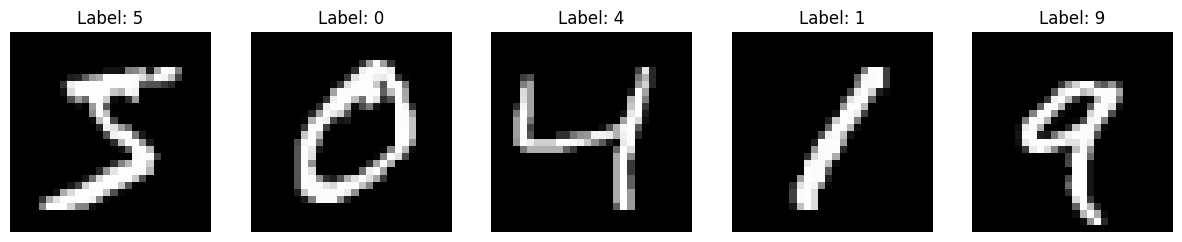

In [ ]:
# Visualize 5 images from the training set
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    image, label = mnist_train_ds[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.show()

### DataLoaders

**DataLoaders** handle batching and shuffling of data:
- **batch_size=32** - Process 32 images at a time (mini-batch gradient descent)
- **shuffle=True** - Randomize training data order each epoch (improves generalization)
- **shuffle=False** - Keep validation data order consistent for reproducibility

In [ ]:
# créaction de 2 data un train et l'autre test
mnist_train_loader = DataLoader(mnist_train_ds, batch_size=32, shuffle=True) # permet de mettre sur la carte graphique l'image
mnist_val_loader = DataLoader(mnist_val_ds, batch_size=32, shuffle=False) #test

## Multi-Layer Perceptron (MLP)

A **Multi-Layer Perceptron** is a fully connected neural network. For image classification:

1. **Flatten** - Convert 2D image (28×28) into 1D vector (784 pixels)
2. **Linear layer** - Fully connected layer: $y = Wx + b$
3. **ReLU activation** - Non-linearity: $\text{ReLU}(x) = \max(0, x)$
4. **Output layer** - 10 neurons (one per digit class)

### Architecture:
```
Input (784) → Linear (128) → ReLU → Linear (10) → Output
```

**Note**: MLPs treat images as flat vectors, losing spatial information. This is a limitation we'll address with CNNs later.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=28*28, n_classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten() # pour transformer un 2d en 1d
        self.fc1 = nn.Linear(input_size, 128)# RN
        self.relu = nn.ReLU() # couche d'activation (consiste à )
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Training Loop

The training process follows these steps for each epoch:

1. **Forward pass** - Compute predictions: `outputs = model(images)`
2. **Compute loss** - Measure error using Cross-Entropy Loss
3. **Backward pass** - Compute gradients: `loss.backward()`
4. **Update weights** - Apply gradients: `optimizer.step()`

### Key Components:
- **CrossEntropyLoss** - Standard loss for multi-class classification (combines LogSoftmax + NLLLoss)
- **SGD Optimizer** - Stochastic Gradient Descent with learning rate 0.001
- **Validation** - Evaluate on unseen data to monitor overfitting

In [ ]:
model = MLP() # on le définie
criterion = nn.CrossEntropyLoss()# quel modèle on souhaite optimiser minimiser la différence entre la classe d'origine et cette prédicte
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Wrap the data loader with tqdm
    progress_bar = tqdm(mnist_train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')#on itère sur ntre dataloader

    for images, labels in progress_bar:
        # Note: Assuming images are already tensors. If using raw MNIST dataset without transforms,
        # you might need to convert images to tensors here using v2.functional.to_dtype or similar.
        outputs = model(images) # on les fait passer dans notre MLP(32,10) car image codé sous 32*32
        loss = criterion(outputs, labels)

        optimizer.zero_grad() # itération de l'optimaserur pour apprendre(on les mets d'abord à 0)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    model.eval()# en mode évalution = pas de calcul de gradd
    total, correct = 0, 0
    with torch.no_grad(): #on le spécifie
        for images, labels in mnist_val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)# max sur les lignes
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(mnist_train_loader)
    accuracy = 100 * correct / total # pour avoir le %
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

Epoch 1/5: 100%|██████████| 1875/1875 [00:16<00:00, 115.39it/s, loss=0.104]


Epoch [1/5], Loss: 0.4653, Validation Accuracy: 94.18%


Epoch 2/5: 100%|██████████| 1875/1875 [00:16<00:00, 115.93it/s, loss=0.0623]


Epoch [2/5], Loss: 0.1722, Validation Accuracy: 95.24%


Epoch 3/5: 100%|██████████| 1875/1875 [00:15<00:00, 120.01it/s, loss=0.0884]


Epoch [3/5], Loss: 0.1289, Validation Accuracy: 95.68%


Epoch 4/5: 100%|██████████| 1875/1875 [00:15<00:00, 117.27it/s, loss=0.104]


Epoch [4/5], Loss: 0.1043, Validation Accuracy: 95.82%


Epoch 5/5: 100%|██████████| 1875/1875 [00:15<00:00, 118.78it/s, loss=0.078]


Epoch [5/5], Loss: 0.0850, Validation Accuracy: 96.28%


## Model Evaluation

### Visual Inspection
Let's visualize some predictions to qualitatively assess model performance:
- **Green** titles = Correct predictions
- **Red** titles = Incorrect predictions

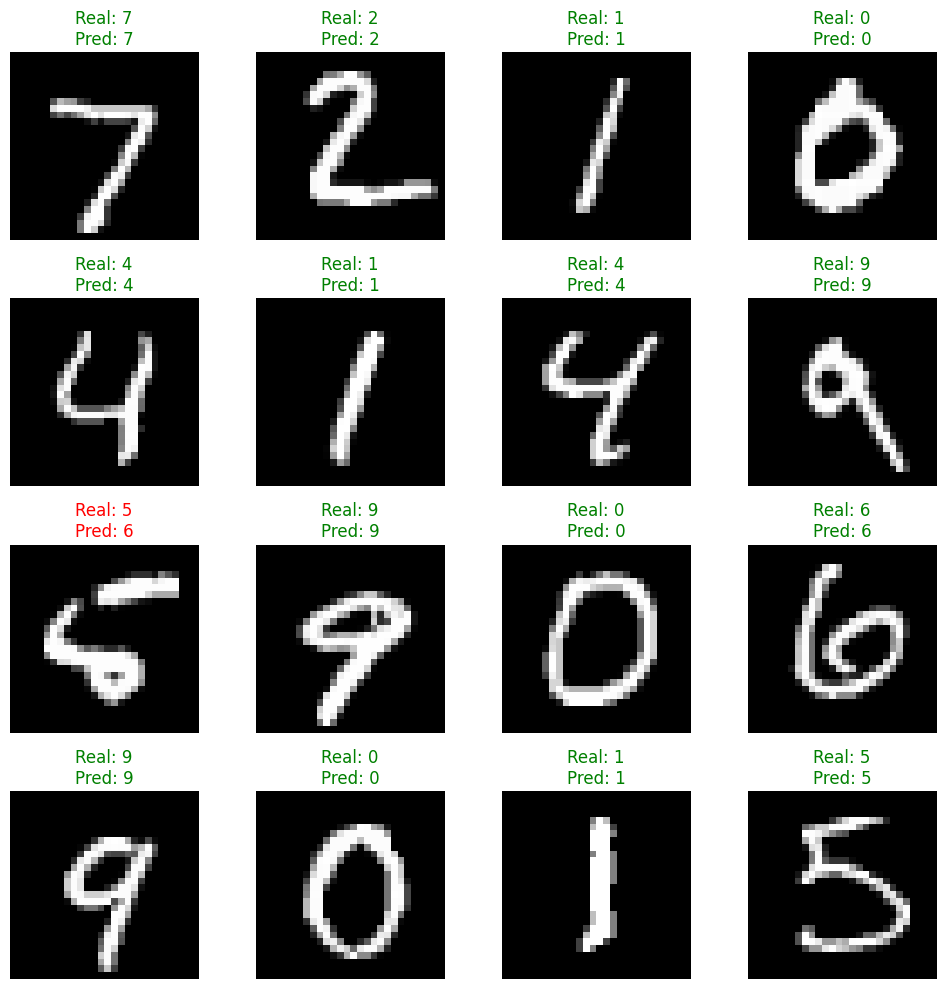

In [ ]:
# Visualize predictions
model.eval()# on sohaite voir si il bien
# on le met en mode eval

# Get a batch of validation images
dataiter = iter(mnist_val_loader)
images, labels = next(dataiter)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i in range(16):
    ax = axes[i // 4, i % 4]
    # Display image
    ax.imshow(images[i].squeeze(), cmap='gray')

    # Set title with Real and Predicted labels
    color = 'green' if predicted[i] == labels[i] else 'red'
    ax.set_title(f'Real: {labels[i].item()}\nPred: {predicted[i].item()}', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Confusion Matrix

A **confusion matrix** shows how predictions are distributed across classes:
- **Diagonal** elements = Correct predictions
- **Off-diagonal** elements = Misclassifications (row = true class, column = predicted class)

This helps identify which digits the model confuses most often (e.g., 4 vs 9, 3 vs 8).

100%|██████████| 313/313 [00:01<00:00, 176.57it/s]


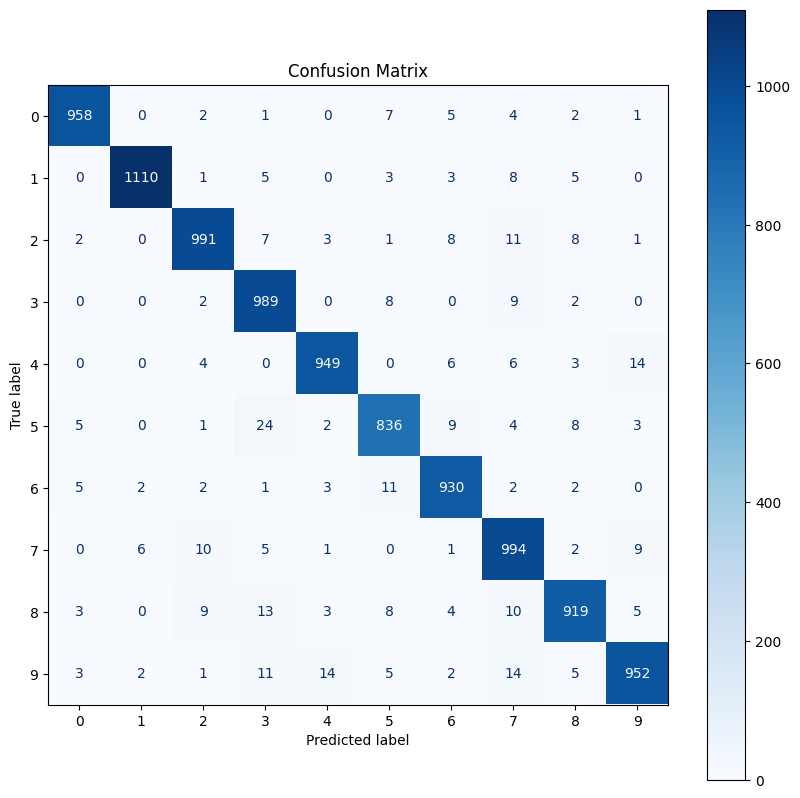

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
# afficher la matrice de confusion
# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(mnist_val_loader):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()
# les résultats les nombres où il a eu comfusion

# Part 2: Classification on CIFAR-10

**CIFAR-10** is more challenging than MNIST:
- **10 classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- **Image size**: 32×32 pixels with **3 color channels** (RGB)
- **Training set**: 50,000 images
- **Test set**: 10,000 images

The key differences from MNIST:
- Color images (3 channels vs 1)
- More complex visual patterns
- Objects have varying poses, scales, and backgrounds

## Data Loading

In [ ]:
cifar_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32),
])

cifar10_train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar10_val_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

100%|██████████| 170M/170M [00:04<00:00, 41.6MB/s]


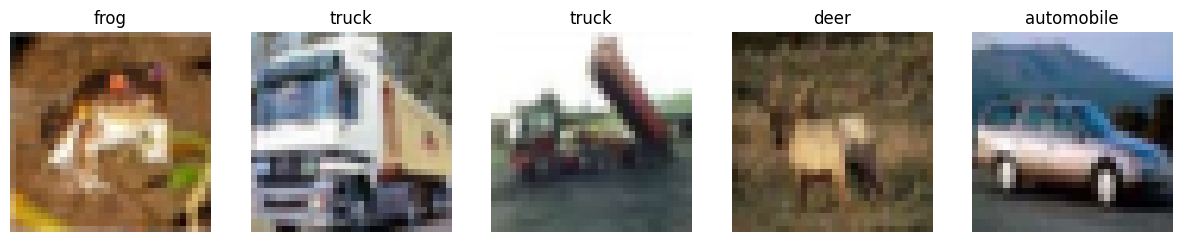

In [ ]:
# Visualize 5 images from the CIFAR-100 training set
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    image, label = cifar10_train_ds[i]
    # Image is (C, H, W), convert to (H, W, C) for matplotlib
    image = image.permute(1, 2, 0)

    # If values are > 1 (0-255 range), normalize to 0-1 for display
    if image.max() > 1.0: # normaliser vu que prend en charge différentes scales.
        image = image / 255.0

    axes[i].imshow(image)

    # Get class name
    label_name = cifar10_train_ds.classes[label]

    axes[i].set_title(f"{label_name}")
    axes[i].axis('off')
plt.show()

## Approach 1: Using a Simple MLP

Let's first try our MLP architecture on CIFAR-10. Since images are 32×32×3, the input size is now **3072** (vs 784 for MNIST).

**Spoiler**: MLPs don't work well on complex images because they:
1. Lose spatial relationships between pixels
2. Have too many parameters (prone to overfitting)
3. Aren't translation invariant

In [ ]:
cifar10_train_loader = DataLoader(cifar10_train_ds, batch_size=32, shuffle=True)
cifar10_val_loader = DataLoader(cifar10_val_ds, batch_size=32, shuffle=False)

In [ ]:
model = MLP(input_size=32*32*3, n_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
num_epochs = 5

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    # Wrap the data loader with tqdm
    progress_bar = tqdm(cifar10_train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in cifar10_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_loss = running_loss / len(mnist_train_loader)
    val_loss = running_loss / len(mnist_val_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

Epoch 1/5: 100%|██████████| 1563/1563 [00:16<00:00, 96.14it/s, loss=2.31]


Epoch [1/5], Loss: 9.2490, Val Loss: 55.4051, Validation Accuracy: 9.99%


Epoch 2/5: 100%|██████████| 1563/1563 [00:15<00:00, 102.24it/s, loss=2.3]


Epoch [2/5], Loss: 1.9202, Val Loss: 11.5025, Validation Accuracy: 9.98%


Epoch 3/5: 100%|██████████| 1563/1563 [00:18<00:00, 85.93it/s, loss=2.29]


Epoch [3/5], Loss: 1.9197, Val Loss: 11.4998, Validation Accuracy: 9.99%


Epoch 4/5: 100%|██████████| 1563/1563 [00:15<00:00, 99.86it/s, loss=2.29] 


Epoch [4/5], Loss: 1.9192, Val Loss: 11.4966, Validation Accuracy: 9.99%


Epoch 5/5: 100%|██████████| 1563/1563 [00:14<00:00, 106.50it/s, loss=2.29]


Epoch [5/5], Loss: 1.9192, Val Loss: 11.4967, Validation Accuracy: 10.01%


### Training Curves Analysis

Plotting **loss** and **accuracy** over epochs helps diagnose training:
- **Training loss decreasing** → Model is learning
- **Validation loss increasing** while training decreases → Overfitting
- **Both losses high and stable** → Underfitting (model too simple or learning rate too low)

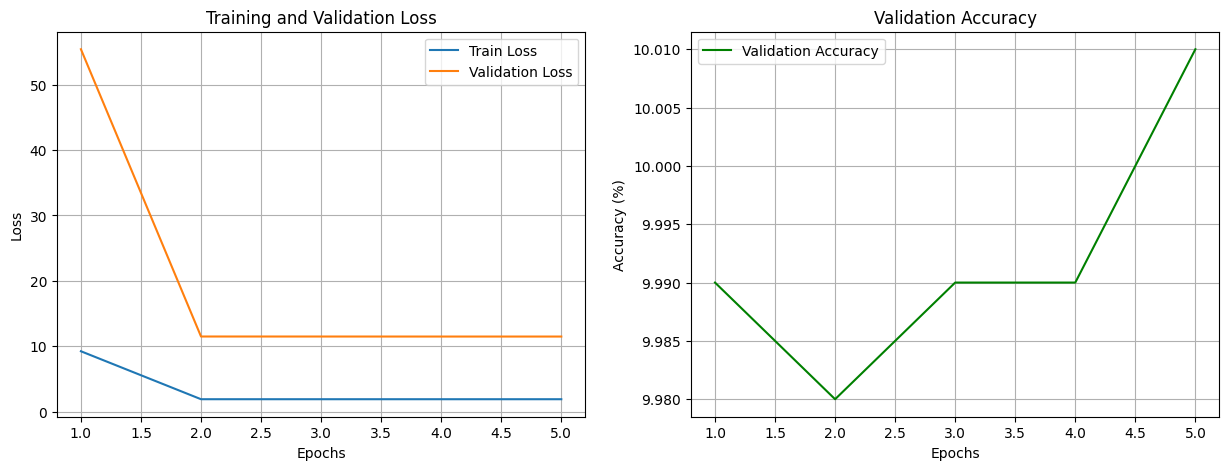

In [ ]:
# important de vérifier cette courbe pour voir le risque de surapprentissage
# Plotting the metrics
epochs_range = range(1, num_epochs + 1)
# on calcul le loss sur les batch et loss surtout en grande dimension
plt.figure(figsize=(15, 5))

# Plot Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()

## Approach 2: Convolutional Neural Network (CNN)

**CNNs** are designed specifically for image data and address MLP limitations:

### Key Components:

1. **Convolutional Layers** (`nn.Conv2d`)
   - Apply learned filters to detect local patterns (edges, textures, shapes)
   - Preserve spatial structure of the image
   - **Parameters**: kernel_size=3, padding=1 maintains spatial dimensions

2. **Pooling Layers** (`nn.MaxPool2d`)
   - Downsample feature maps (reduce spatial dimensions by half)
   - Provide translation invariance
   - Reduce computation and parameters

3. **Dropout** (`nn.Dropout(0.5)`)# ce dernier nous permet d'être sur que le train et le test ne se rencontre pas
avec 50% de moins , l'entrainement sera moins bien ,cependant l'accuracy sera mieux
   - Randomly zero 50% of neurons during training
   - Prevents overfitting by forcing redundant representations

### Architecture:
```
Input (3×32×32)
  ↓ Conv(3→32) + ReLU + MaxPool → (32×16×16)
  ↓ Conv(32→64) + ReLU + MaxPool → (64×8×8)
  ↓ Conv(64→128) + ReLU + MaxPool → (128×4×4)
  ↓ Flatten → (2048)
  ↓ Linear(512) + ReLU + Dropout
  ↓ Linear(10) → Output
```

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(# on passe chacun l'un après l'autre
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),# on rajoute du padding pour éviter de perdre les bords
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),# divise le hauteur et la largeur en 2
            # stride minimiser sans perdre de l'info
            # on souhiate que la compression ne se passe que au niveau du maxPool2d
            # padding permet d'avoir de l'info uniformement chaque case est vu le même nbre de fois
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# cannaux de 32 to 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Training the CNN

We train for more epochs (10 vs 5) since CNNs have more parameters and need more time to converge. Notice how the CNN achieves significantly better accuracy than the MLP on CIFAR-10!

In [ ]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model_cnn = SimpleCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.001)
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model_cnn.train()
    running_loss = 0.0

    progress_bar = tqdm(cifar10_train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    model_cnn.eval()
    total, correct = 0, 0
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in cifar10_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_loss = running_loss / len(cifar10_train_loader)
    val_loss = running_val_loss / len(cifar10_val_loader)
    accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

Epoch 1/10: 100%|██████████| 1563/1563 [01:18<00:00, 19.79it/s, loss=1.66]


Epoch [1/10], Loss: 1.8176, Val Loss: 1.4901, Validation Accuracy: 47.26%


Epoch 2/10: 100%|██████████| 1563/1563 [01:16<00:00, 20.47it/s, loss=1.16]


Epoch [2/10], Loss: 1.4911, Val Loss: 1.3778, Validation Accuracy: 50.48%


Epoch 3/10: 100%|██████████| 1563/1563 [01:15<00:00, 20.69it/s, loss=1.81]


Epoch [3/10], Loss: 1.3587, Val Loss: 1.2943, Validation Accuracy: 54.45%


Epoch 4/10: 100%|██████████| 1563/1563 [01:15<00:00, 20.75it/s, loss=1.64]


Epoch [4/10], Loss: 1.2656, Val Loss: 1.2155, Validation Accuracy: 57.83%


Epoch 5/10: 100%|██████████| 1563/1563 [01:16<00:00, 20.51it/s, loss=1.1]


Epoch [5/10], Loss: 1.1857, Val Loss: 1.1433, Validation Accuracy: 59.69%


Epoch 6/10: 100%|██████████| 1563/1563 [01:20<00:00, 19.53it/s, loss=0.91]


Epoch [6/10], Loss: 1.1192, Val Loss: 1.1227, Validation Accuracy: 60.44%


Epoch 7/10: 100%|██████████| 1563/1563 [01:16<00:00, 20.53it/s, loss=1.27]


Epoch [7/10], Loss: 1.0644, Val Loss: 1.0496, Validation Accuracy: 63.41%


Epoch 8/10: 100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s, loss=1.03]


Epoch [8/10], Loss: 1.0215, Val Loss: 0.9735, Validation Accuracy: 65.99%


Epoch 9/10: 100%|██████████| 1563/1563 [01:20<00:00, 19.49it/s, loss=1.31]


Epoch [9/10], Loss: 0.9730, Val Loss: 0.9697, Validation Accuracy: 66.11%


Epoch 10/10: 100%|██████████| 1563/1563 [01:19<00:00, 19.78it/s, loss=1.03]


Epoch [10/10], Loss: 0.9367, Val Loss: 1.0204, Validation Accuracy: 63.98%


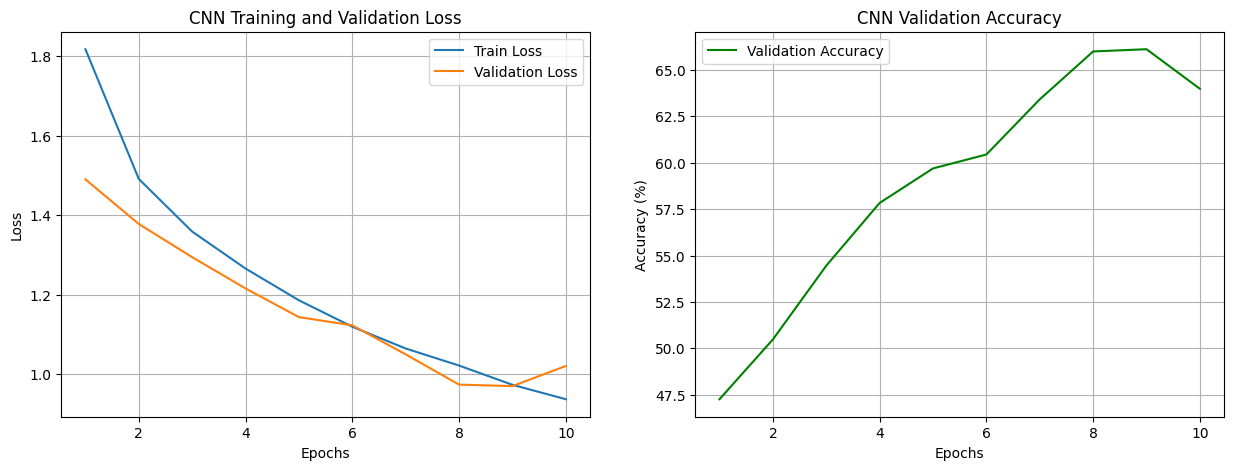

In [ ]:
# Plotting the metrics for CNN
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

# Plot Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('CNN Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()

## CNN Evaluation

### Visual Predictions
Let's see how the CNN performs on some validation images:

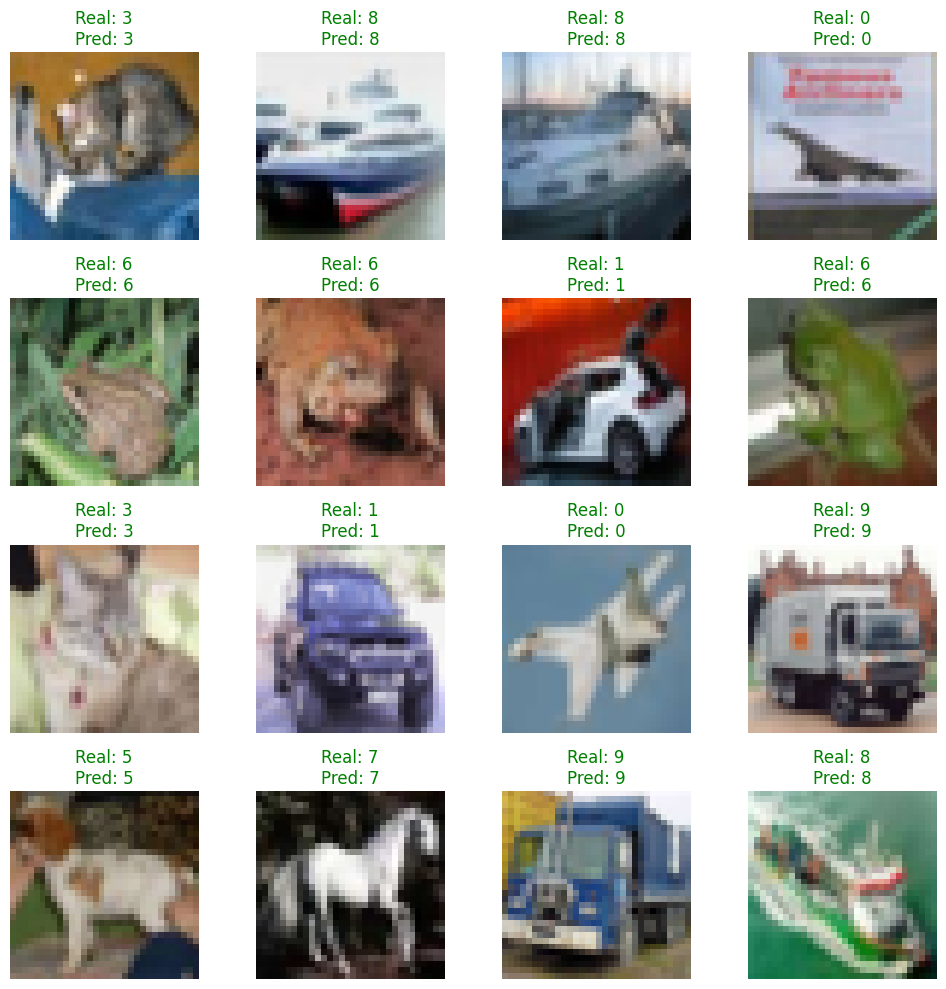

In [ ]:
# Visualize predictions
model.eval()

# Get a batch of validation images
dataiter = iter(cifar10_val_loader)
images, labels = next(dataiter)# pour passer au suivant normalement
images, labels = images.to(device), labels.to(device)# mettre l'image dans le GPU

with torch.no_grad():
    outputs = model_cnn(images)
    _, predicted = torch.max(outputs, 1)

# Plot 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i in range(16):
    ax = axes[i // 4, i % 4]
    # Display image
    image = images[i].permute(1, 2, 0).cpu().numpy()
    if image.max() > 1.0:
        image = image / 255.0

    ax.imshow(image)
    # Set title with Real and Predicted labels
    color = 'green' if predicted[i] == labels[i] else 'red'
    ax.set_title(f'Real: {labels[i].item()}\nPred: {predicted[i].item()}', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

100%|██████████| 313/313 [00:08<00:00, 35.42it/s]


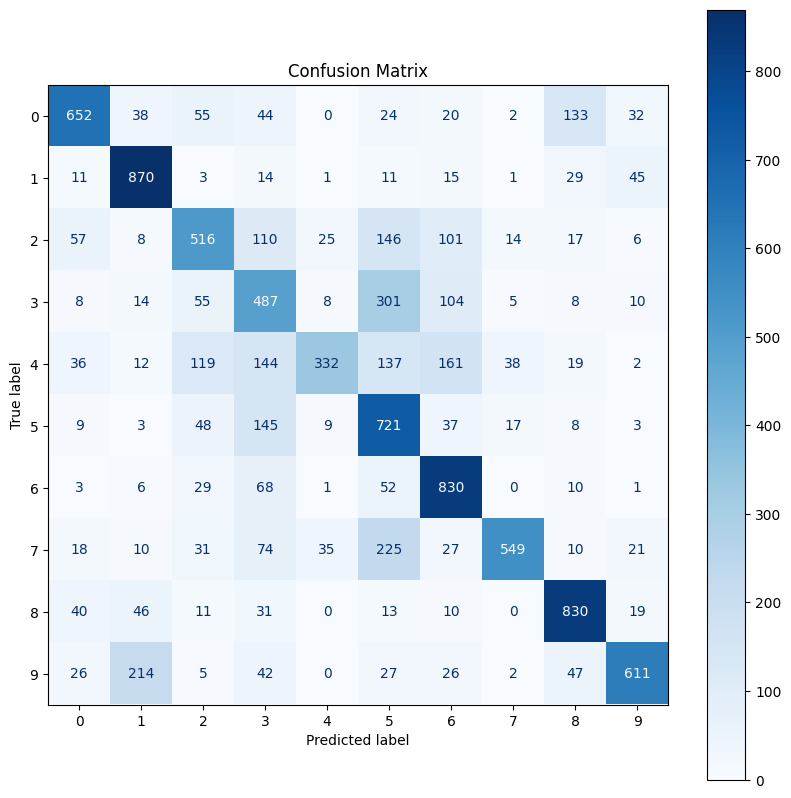

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Collect all predictions and true labels
all_preds = []
all_labels = []

model_cnn.eval()
with torch.no_grad():
    for images, labels in tqdm(cifar10_val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

---

## Summary

| Model | Dataset | Input Size | Key Characteristics |
|-------|---------|------------|---------------------|
| MLP | MNIST | 784 | Simple, loses spatial info |
| MLP | CIFAR-10 | 3072 | Struggles with complex images |
| CNN | CIFAR-10 | 3×32×32 | Preserves spatial structure, better accuracy |

### Key Takeaways:

1. **MLPs** work for simple images (MNIST) but fail on complex ones (CIFAR-10)
2. **CNNs** leverage spatial structure through convolutions and pooling

### Next Steps:
- Try **data augmentation**

### Confusion Matrix for CNN

Analyze which classes the CNN confuses most. Common confusions include:
- **cat ↔ dog** (similar shapes)
- **automobile ↔ truck** (both are vehicles)
- **deer ↔ horse** (four-legged animals)

---

# Part 3: Data Augmentation

**Data Augmentation** is a regularization technique that artificially increases the size and diversity of your training dataset by applying random transformations to images. This helps the model:
- **Generalize better** to unseen data
- **Reduce overfitting** by seeing more variations
- **Learn invariances** (e.g., a cat is still a cat when flipped)

## Common Data Augmentation Techniques

| Technique | Description | Use Case |
|-----------|-------------|----------|
| **Random Horizontal Flip** | Mirror image left-right with random probability | Most natural images (not text/digits) |
| **Random Vertical Flip** | Mirror image top-bottom | Aerial/satellite images, microscopy |
| **Random Rotation** | Rotate by random angle | When orientation doesn't matter |
| **Random Crop** | Extract random sub-region, then resize | Adds translation invariance |
| **Color Jitter** | Random changes to brightness, contrast, saturation, hue | Robustness to lighting conditions |
| **Random Erasing / Cutout** | Randomly mask rectangular regions | Forces model to use all features |
| **Gaussian Blur** | Apply random blur | Robustness to image quality |
| **Normalization** | Standardize pixel values (mean=0, std=1) | Faster convergence, not augmentation per se |

### Important Notes:
- **Only augment training data** - validation/test data should remain unchanged
- **Choose augmentations that make sense** for your data (e.g., don't flip digits)
- Augmentation is applied **on-the-fly** during training (different each epoch)

## Configurable CIFAR-10 Dataset with Augmentation

We'll create a function that returns CIFAR-10 datasets with optional data augmentation. This makes it easy to compare training with and without augmentation.

In [ ]:
def get_cifar10_datasets(use_augmentation=False, normalize=True):
    """
    Create CIFAR-10 train and validation datasets with configurable augmentation.

    Args:
        use_augmentation: If True, apply data augmentation to training set
        normalize: If True, normalize images using CIFAR-10 mean and std

    Returns:
        train_dataset, val_dataset
    """
    # CIFAR-10 normalization values (pre-computed from the dataset)
    cifar10_mean = (0.4914, 0.4822, 0.4465)
    cifar10_std = (0.2470, 0.2435, 0.2616)

    # Base transforms (always applied)
    base_transforms = [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),  # scale=True normalizes to [0, 1]# important de la mettre en float 32
    ]

    # Add normalization if requested
    if normalize:
        base_transforms.append(v2.Normalize(mean=cifar10_mean, std=cifar10_std))

    # Augmentation transforms (only for training)
    augmentation_transforms = [
        v2.RandomHorizontalFlip(p=0.5),           # 50% chance to flip horizontally
        v2.RandomRotation(degrees=15),             # Rotate up to ±15 degrees
        v2.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),                  # Shift up to 10% in each direction
            scale=(0.9, 1.1)                       # Scale between 90% and 110%
        ),
        v2.ColorJitter(
            brightness=0.2,                        # ±20% brightness
            contrast=0.2,                          # ±20% contrast
            saturation=0.2,                        # ±20% saturation
            hue=0.1                                # ±10% hue shift
        ),
    ]

    # Build training transform
    if use_augmentation:
        train_transform = v2.Compose([ # les transforme on les mets que sur les train
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            *augmentation_transforms,
            v2.Normalize(mean=cifar10_mean, std=cifar10_std) if normalize else v2.Identity(),
        ])
    else:
        train_transform = v2.Compose(base_transforms)

    # Validation transform (never augmented)
    val_transform = v2.Compose(base_transforms)

    # Create datasets
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

    return train_dataset, val_dataset

### Visualize Augmentation Effects

Let's see what augmented images look like compared to originals:

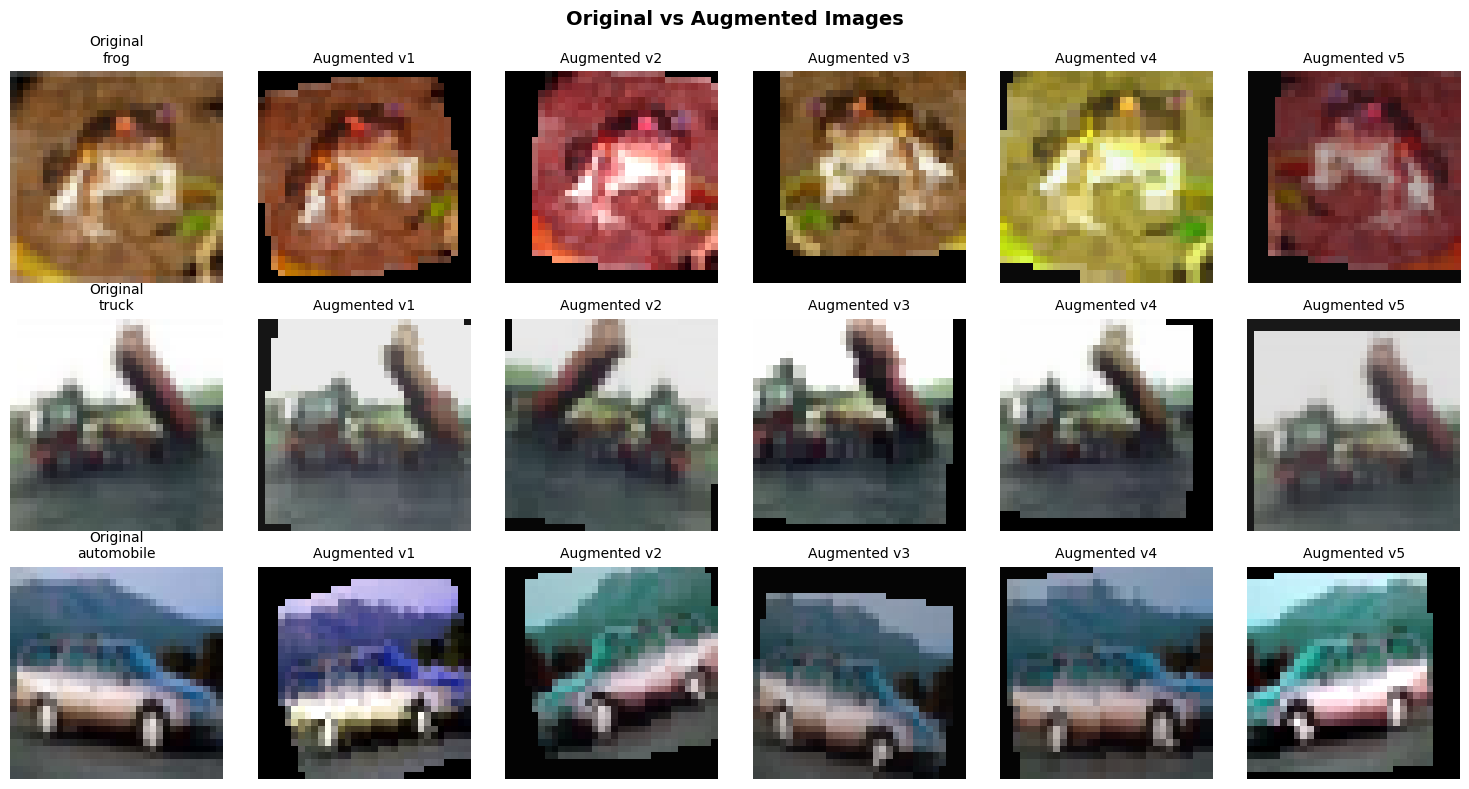

In [ ]:
# fonction pour visualiser les augmentations
# Create datasets with and without augmentation (no normalization for visualization)
train_no_aug, _ = get_cifar10_datasets(use_augmentation=False, normalize=False)
train_with_aug, _ = get_cifar10_datasets(use_augmentation=True, normalize=False)

# Visualize same images with different augmentations
fig, axes = plt.subplots(3, 6, figsize=(15, 8))

for row in range(3):
    idx = row * 2  # Get different base images

    # Original image (left column)
    original_img, label = train_no_aug[idx]
    original_img = original_img.permute(1, 2, 0).numpy()
    original_img = np.clip(original_img, 0, 1)

    axes[row, 0].imshow(original_img)
    axes[row, 0].set_title(f"Original\n{train_no_aug.classes[label]}", fontsize=10)
    axes[row, 0].axis('off')

    # Show 5 different augmented versions of the same image
    for col in range(1, 6):
        aug_img, _ = train_with_aug[idx]
        aug_img = aug_img.permute(1, 2, 0).numpy()
        aug_img = np.clip(aug_img, 0, 1)

        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(f"Augmented v{col}", fontsize=10)
        axes[row, col].axis('off')

plt.suptitle("Original vs Augmented Images", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Training Function

We'll create a reusable training function to compare models with and without augmentation:

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device='cpu'):
    """
    Train a model and return training history.

    Returns:
        dict with 'train_losses', 'val_losses', 'val_accuracies'
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam often works better

    history = {
        'train_losses': [],
        'val_losses': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Record metrics
        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_accuracy = 100 * correct / total

        history['train_losses'].append(epoch_train_loss)
        history['val_losses'].append(epoch_val_loss)
        history['val_accuracies'].append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Acc: {epoch_accuracy:.2f}%')

    return history

## Experiment: With vs Without Data Augmentation

Now let's train two identical CNN models:
1. **Without augmentation** - Standard training
2. **With augmentation** - Using our augmentation pipeline

We'll train for 15 epochs to see the effect of augmentation over time.

In [ ]:
# Configuration
NUM_EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Select device
device = torch.device('cuda' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Training WITHOUT Data Augmentation

In [ ]:
# Create datasets WITHOUT augmentation
train_ds_no_aug, val_ds_no_aug = get_cifar10_datasets(use_augmentation=False, normalize=True)

train_loader_no_aug = DataLoader(train_ds_no_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_no_aug = DataLoader(val_ds_no_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Create and train model
print("=" * 50)
print("Training CNN WITHOUT Data Augmentation")
print("=" * 50)

model_no_aug = SimpleCNN(num_classes=10).to(device)
history_no_aug = train_model(
    model_no_aug,
    train_loader_no_aug,
    val_loader_no_aug,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device
)

Training CNN WITHOUT Data Augmentation


Epoch [1/15] - Train Loss: 1.4058, Val Loss: 1.0288, Val Acc: 63.68%


Epoch [2/15] - Train Loss: 0.9774, Val Loss: 0.8890, Val Acc: 69.18%


Epoch [3/15] - Train Loss: 0.8128, Val Loss: 0.7888, Val Acc: 72.59%


Epoch [4/15] - Train Loss: 0.6961, Val Loss: 0.7742, Val Acc: 72.91%


Epoch [5/15] - Train Loss: 0.6212, Val Loss: 0.6866, Val Acc: 76.48%


Epoch [6/15] - Train Loss: 0.5505, Val Loss: 0.7531, Val Acc: 75.58%


Epoch [7/15] - Train Loss: 0.4918, Val Loss: 0.7003, Val Acc: 77.01%


Epoch [8/15] - Train Loss: 0.4386, Val Loss: 0.7329, Val Acc: 76.55%


Epoch [9/15] - Train Loss: 0.3924, Val Loss: 0.7972, Val Acc: 75.07%


Epoch [10/15] - Train Loss: 0.3567, Val Loss: 0.7385, Val Acc: 77.11%


Epoch [11/15] - Train Loss: 0.3207, Val Loss: 0.7879, Val Acc: 76.29%


Epoch [12/15] - Train Loss: 0.2960, Val Loss: 0.8217, Val Acc: 77.02%


Epoch [13/15] - Train Loss: 0.2747, Val Loss: 0.8627, Val Acc: 76.29%


Epoch [14/15] - Train Loss: 0.2463, Val Loss: 0.8928, Val Acc: 77.17%


Epoch [15/15] - Train Loss: 0.2382, Val Loss: 0.9400, Val Acc: 76.39%


### Training WITH Data Augmentation

In [ ]:
# Create datasets WITH augmentation
train_ds_aug, val_ds_aug = get_cifar10_datasets(use_augmentation=True, normalize=True)

train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_aug = DataLoader(val_ds_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Create and train model (same architecture, fresh weights)
print("\n" + "=" * 50)
print("Training CNN WITH Data Augmentation")
print("=" * 50)

model_with_aug = SimpleCNN(num_classes=10).to(device)
history_with_aug = train_model(
    model_with_aug,
    train_loader_aug,
    val_loader_aug,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device
)


Training CNN WITH Data Augmentation


Epoch [1/15] - Train Loss: 1.6612, Val Loss: 1.2497, Val Acc: 54.80%


Epoch [2/15] - Train Loss: 1.3429, Val Loss: 1.1046, Val Acc: 60.13%


Epoch [3/15] - Train Loss: 1.1856, Val Loss: 0.9650, Val Acc: 65.05%


Epoch [4/15] - Train Loss: 1.0924, Val Loss: 0.8872, Val Acc: 68.60%


Epoch [5/15] - Train Loss: 1.0353, Val Loss: 0.8601, Val Acc: 69.74%


Epoch [6/15] - Train Loss: 0.9933, Val Loss: 0.8001, Val Acc: 71.89%


Epoch [7/15] - Train Loss: 0.9594, Val Loss: 0.7420, Val Acc: 74.51%


Epoch [8/15] - Train Loss: 0.9289, Val Loss: 0.7241, Val Acc: 75.16%


Epoch [9/15] - Train Loss: 0.9113, Val Loss: 0.7547, Val Acc: 74.46%


Epoch [10/15] - Train Loss: 0.8883, Val Loss: 0.7015, Val Acc: 76.04%


Epoch [11/15] - Train Loss: 0.8676, Val Loss: 0.6845, Val Acc: 75.99%


Epoch [12/15] - Train Loss: 0.8595, Val Loss: 0.6644, Val Acc: 76.84%


Epoch [13/15] - Train Loss: 0.8501, Val Loss: 0.6695, Val Acc: 76.72%


Epoch [14/15] - Train Loss: 0.8377, Val Loss: 0.6573, Val Acc: 77.19%


Epoch [15/15] - Train Loss: 0.8268, Val Loss: 0.6565, Val Acc: 76.96%


## Comparing Results

Let's visualize the training curves side by side to see the effect of data augmentation:

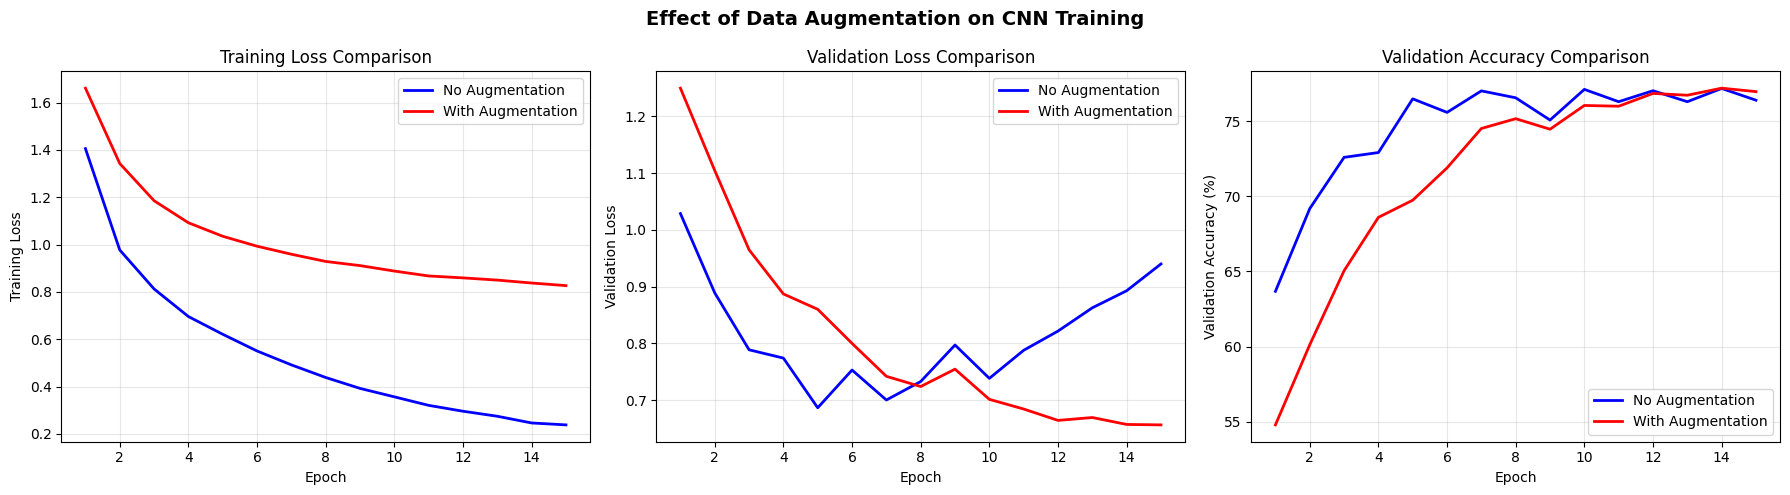


FINAL RESULTS SUMMARY

Without Augmentation:
  - Best Validation Accuracy: 77.17%
  - Final Validation Accuracy: 76.39%
  - Final Training Loss: 0.2382
  - Final Validation Loss: 0.9400

With Augmentation:
  - Best Validation Accuracy: 77.19%
  - Final Validation Accuracy: 76.96%
  - Final Training Loss: 0.8268
  - Final Validation Loss: 0.6565

📈 Improvement with augmentation: +0.02%


In [ ]:
import numpy as np

epochs_range = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training Loss Comparison
axes[0].plot(epochs_range, history_no_aug['train_losses'], 'b-', label='No Augmentation', linewidth=2)
axes[0].plot(epochs_range, history_with_aug['train_losses'], 'r-', label='With Augmentation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Loss Comparison
axes[1].plot(epochs_range, history_no_aug['val_losses'], 'b-', label='No Augmentation', linewidth=2)
axes[1].plot(epochs_range, history_with_aug['val_losses'], 'r-', label='With Augmentation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Validation Accuracy Comparison
axes[2].plot(epochs_range, history_no_aug['val_accuracies'], 'b-', label='No Augmentation', linewidth=2)
axes[2].plot(epochs_range, history_with_aug['val_accuracies'], 'r-', label='With Augmentation', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Validation Accuracy (%)')
axes[2].set_title('Validation Accuracy Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Effect of Data Augmentation on CNN Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"\nWithout Augmentation:")
print(f"  - Best Validation Accuracy: {max(history_no_aug['val_accuracies']):.2f}%")
print(f"  - Final Validation Accuracy: {history_no_aug['val_accuracies'][-1]:.2f}%")
print(f"  - Final Training Loss: {history_no_aug['train_losses'][-1]:.4f}")
print(f"  - Final Validation Loss: {history_no_aug['val_losses'][-1]:.4f}")

print(f"\nWith Augmentation:")
print(f"  - Best Validation Accuracy: {max(history_with_aug['val_accuracies']):.2f}%")
print(f"  - Final Validation Accuracy: {history_with_aug['val_accuracies'][-1]:.2f}%")
print(f"  - Final Training Loss: {history_with_aug['train_losses'][-1]:.4f}")
print(f"  - Final Validation Loss: {history_with_aug['val_losses'][-1]:.4f}")

# Calculate improvement
improvement = max(history_with_aug['val_accuracies']) - max(history_no_aug['val_accuracies'])
print(f"\n📈 Improvement with augmentation: {improvement:+.2f}%")

### Analysis: Understanding the Results

**What to observe:**

1. **Training Loss**:
   - Without augmentation: Decreases quickly and can become very low
   - With augmentation: Decreases more slowly (harder task due to varied inputs)

2. **Validation Loss**:
   - Without augmentation: May increase after initial decrease (overfitting!)
   - With augmentation: More stable, often continues to decrease

3. **Gap between Train and Val loss**:
   - Large gap = Overfitting (model memorizing training data)
   - Small gap = Good generalization

4. **Validation Accuracy**:
   - With augmentation: Usually higher final accuracy
   - The improvement becomes more pronounced with longer training

**Key insight**: Data augmentation acts as a regularizer. The model trains on slightly different versions of each image every epoch, making it harder to memorize but easier to generalize.